# Advanced Lane Finding Project

### Imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os


%matplotlib inline

#### IMAGE CALIBRATION

(720, 1280, 3)
(721, 1281, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(721, 1281, 3)
(720, 1280, 3)
(720, 1280, 3)


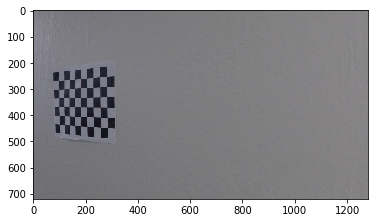

In [2]:
nx = 9
ny = 6

object_points = []
image_points = []

objpoints = np.zeros((nx*ny,3), np.float32)
objpoints[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

folder = 'camera_cal'
#for loop to read all the images in the folder
for filename in os.listdir(folder):
    img = mpimg.imread(os.path.join(folder, filename))
    image_shape = img.shape
    print(image_shape)
    plt.imshow(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        object_points.append(objpoints)
        image_points.append(corners)
        
# using object and image points to calibrate camera and find c-matrix and distortion coefficients
ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, image_shape[:2],None,None)


*some of these images do not appear because the specified number of chessboard corners were not found*

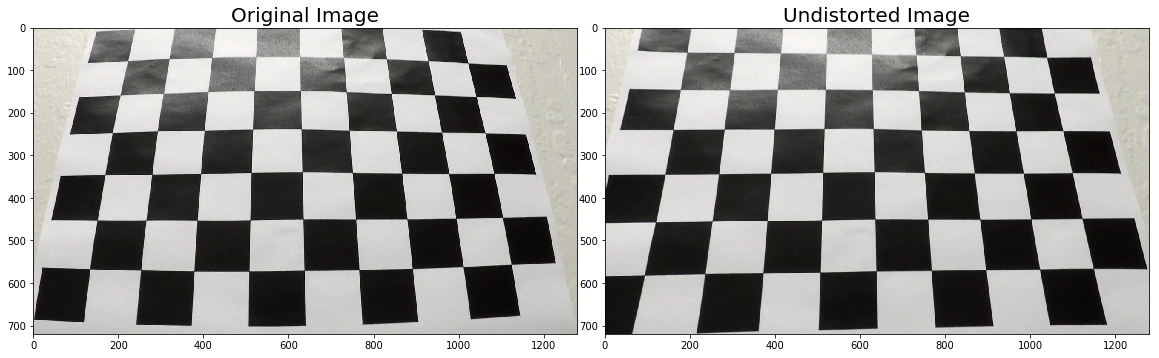

In [3]:
originalimg = mpimg.imread('camera_cal/calibration3.jpg')
undistortedimg = cv2.undistort(originalimg, cameraMatrix, distortionCoeffs, None, cameraMatrix)

# plot images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(originalimg)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistortedimg)
ax2.set_title('Undistorted Image', fontsize=20)

#SAVING UNDISTORTED IMAGES FOR REFERENCE
folder = 'camera_cal'
#for loop to read all the images in the folder
for filename in os.listdir(folder):
    image = mpimg.imread(os.path.join(folder, filename))
    undistortedimg = cv2.undistort(image, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    cv2.imwrite('undistorted_imgs/%s'%filename, undistortedimg)


TESTING THE DISTORTION CODE

True

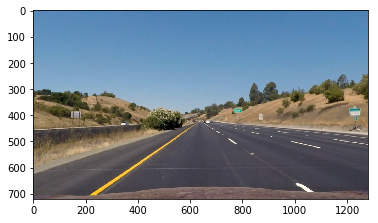

In [4]:
originalimg = mpimg.imread('test_images/straight_lines1.jpg')
undistortedimg = cv2.undistort(originalimg, cameraMatrix, distortionCoeffs, None, cameraMatrix)
plt.imshow(undistortedimg)
cv2.imwrite('straight_lines1_undistorted.jpg', cv2.cvtColor(undistortedimg, cv2.COLOR_RGB2BGR))

### THRESHOLDING IMAGE AND UNDISTORTING THE IMAGE

We will first use colour thresholding and we will achieve this in 3 step process since we not only need to worry about seperating line but also about varying light conditions which will make it harder. The 3 steps are-

 Step1- Apply gradient threshold in X direction
 
 Step2- Apply directional gradient since most lanelines are close to vertical (threshold are 30 and 120)

 Step3- We apply a RGB threshold since yellow lines can be seperated
 
 Step4- HLS Threshold to remove shadows which effects edge detection and helps seperate yellow and white lines easily
 
 Step5- We combine all the above thresholds to get a clean binary image for the lane lines
 
 Finally we apply the undistortion to the image and get the undistorted thresholded image we can start working on!!

In [5]:
def direction_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
# Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    directionmask = np.zeros_like(direction)
    directionmask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return directionmask

In [6]:
def image_thresholding(img):
    
    img = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    # converting to gray scale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    height, width = gray_img.shape
    
    # apply gradient threshold on the horizontal gradient

    sobel_img = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobel = np.absolute(sobel_img)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    sobelX_binay = np.zeros_like(binary_output)
    sobelX_binay[(binary_output >= 10) & (binary_output <= 200)] = 1
    
    #Direction Gradient to fins edges that are almost vertical
    direction_binary = direction_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    #Adding the directional and horizontal gradient thresholds
    Gradient_filtered=((sobelX_binay == 1) & (direction_binary == 1))
    
    # RGB thresholding
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    RGB_filtered = (R > color_threshold) & (G > color_threshold)
    
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # HLS THRESHOLDING 
    s_thresh = (100, 255)
    Saturation_filtered = (S > s_thresh[0]) & (S <= s_thresh[1])
    l_thresh = (120, 255)
    Light_filtered = (L > l_thresh[0]) & (L <= l_thresh[1])

    # Combining all the GRADIENT, RGB and the HLS thresholds
    color_combined[(RGB_filtered & Light_filtered) & (Saturation_filtered | Gradient_filtered)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded_img = cv2.bitwise_and(color_combined, mask)
    
    return thresholded_img
    
    

    

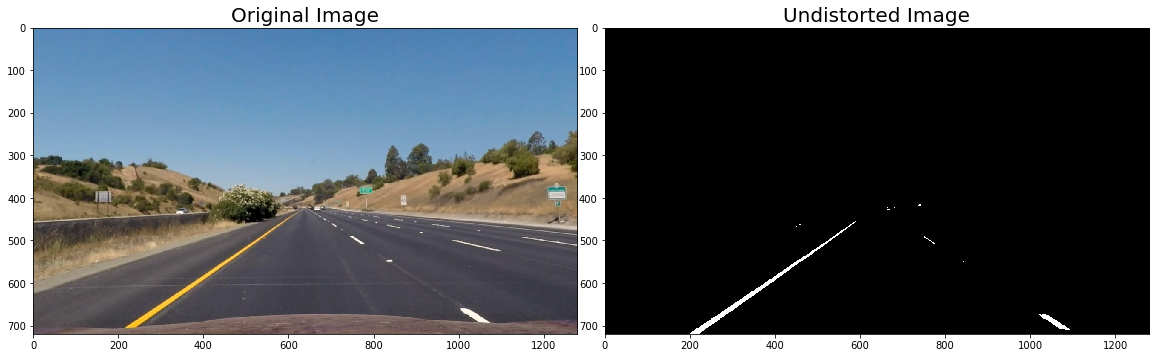

In [7]:
img = mpimg.imread('test_images/straight_lines1.jpg')
thresholded = image_thresholding(img)
img=cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
undistort_img = cv2.undistort(thresholded, cameraMatrix, distortionCoeffs, None, cameraMatrix)
copy=np.copy(undistort_img)
copy=copy*255
cv2.imwrite('thresholded_undistorted.jpg',copy)


# plot images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistort_img, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=20)

### Perspective Transform

Now we will start with the perspective transform which can now get us the lane markes to compute lane curvature. To start we define a region of interest which we will take the transformation on and since mostly the lanes appear in the specific region of image we can hardcode the ROI polygon. 

We will compute the transformation and its inverse now.


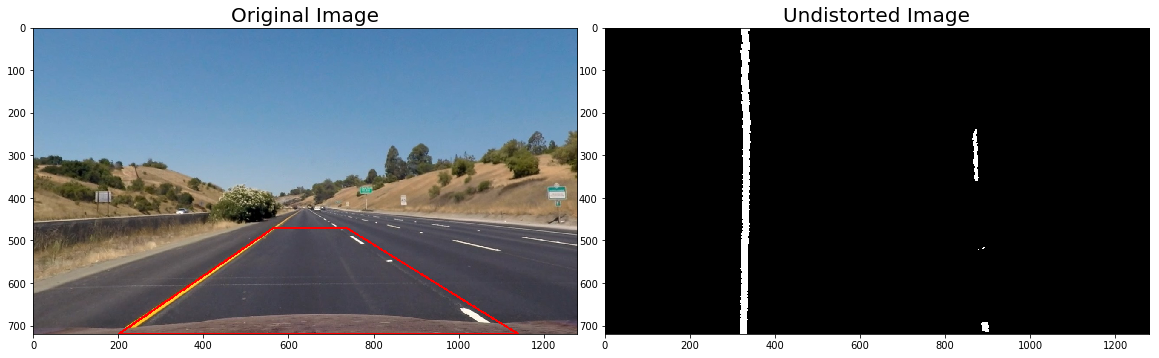

In [8]:
source = np.float32([(200,720),(1140,720),(735,470),(565,470)])

pts = np.array([(200,720),(1140,720),(735,470),(565,470)], np.int32)
pts = pts.reshape((-1,1,2))
copy = img.copy()
cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)


dst = np.float32([(320,720),(920,720),(920,1),(320,1)])
M = cv2.getPerspectiveTransform(source, dst)
M_inv = cv2.getPerspectiveTransform(dst, source)
img_size = (image_shape[1], image_shape[0])

warped_img = cv2.warpPerspective(undistort_img, M, img_size , flags=cv2.INTER_LINEAR)
copy_warped=np.copy(warped_img)
copy_warped=copy_warped*255
cv2.imwrite('perspective_transform.jpg',copy_warped)
cv2.imwrite('perspective_transform_polygon.jpg',cv2.cvtColor(copy, cv2.COLOR_RGB2BGR))


# plot images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(copy)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped_img, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=20)

### HISTROGRAM EVALUATION TO IDENTIFY PIXELS

Histogram evalution gives info about the position of lane markers in the warped image.

324 887


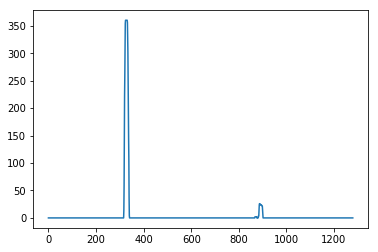

In [9]:
histogram = np.sum(warped_img[round(warped_img.shape[0]/2):,:], axis=0)

# left lane marker
width_half = np.int(histogram.shape[0]/2)
leftpeak = np.argmax(histogram[:width_half])

# right lane marker
rigthpeak= np.argmax(histogram[width_half:]) + width_half

print(leftpeak, rigthpeak)
plt.plot(histogram)

#### SLIDING WINDOW BASED SEARCH

(720, 0)

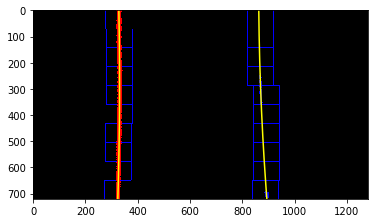

In [10]:
out_img = np.dstack((warped_img, warped_img, warped_img))*255

non_zeros = warped_img.nonzero()
non_zeros_y = non_zeros[0]
non_zeros_x = non_zeros[1]

num_windows = 10
num_rows = warped_img.shape[0]
window_height = np.int(num_rows/num_windows)
window_half_width = 50

min_pixels = 100

left_coordinates = []
right_coordinates = []

for window in range(num_windows):
    y_max = num_rows - window*window_height
    y_min = num_rows - (window+1)* window_height
    
    left_x_min = leftpeak - window_half_width
    left_x_max = leftpeak + window_half_width
    
    cv2.rectangle(out_img, (left_x_min, y_min), (left_x_max, y_max), [0,0,255],2)
    
    good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
    left_coordinates.append(good_left_window_coordinates)
    
    if len(good_left_window_coordinates) > min_pixels:
        leftpeak = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))
    
    right_x_min = rigthpeak - window_half_width
    right_x_max = rigthpeak + window_half_width
    
    cv2.rectangle(out_img, (right_x_min, y_min), (right_x_max, y_max), [0,0,255],2)
    
    good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
    right_coordinates.append(good_right_window_coordinates)
        
    if len(good_right_window_coordinates) > min_pixels:
        rigthpeak = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))
        
left_coordinates = np.concatenate(left_coordinates)
right_coordinates = np.concatenate(right_coordinates)

out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]

left_x = non_zeros_x[left_coordinates]
left_y = non_zeros_y[left_coordinates]

polyfit_left = np.polyfit(left_y, left_x, 2)

right_x = non_zeros_x[right_coordinates]
right_y = non_zeros_y[right_coordinates]

polyfit_right = np.polyfit(right_y, right_x, 2)

y_points = np.linspace(0, num_rows-1, num_rows)

left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

plt.imshow(out_img)
plt.plot(left_x_predictions, y_points, color='yellow')
plt.plot(right_x_predictions, y_points, color='yellow')
plt.xlim(0,warped_img.shape[1])
plt.ylim(warped_img.shape[0],0)

### Searching around a previously detected line.

This idea was from a previous graduate of the course to search aroung the lines for fixed pixels since consecutive frames are likely to have lanes in similar positions

(720, 0)

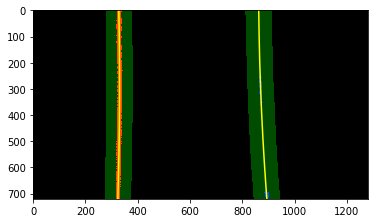

In [11]:
margin = 50
out_img = np.dstack((warped_img, warped_img, warped_img))*255

left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]

out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]


left_x = non_zeros_x[left_coordinates]
left_y = non_zeros_y[left_coordinates]

polyfit_left = np.polyfit(left_y, left_x, 2)

right_x = non_zeros_x[right_coordinates]
right_y = non_zeros_y[right_coordinates]

polyfit_right = np.polyfit(right_y, right_x, 2)

y_points = np.linspace(0, num_rows-1, num_rows)

left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

window_img = np.zeros_like(out_img)

left_line_window_1 = np.array(np.transpose(np.vstack([left_x_predictions - margin, y_points])))

left_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([left_x_predictions + margin, y_points]))))

left_line_points = np.vstack((left_line_window_1, left_line_window_2))

cv2.fillPoly(window_img, np.int_([left_line_points]), [0,255, 0])

right_line_window_1 = np.array(np.transpose(np.vstack([right_x_predictions - margin, y_points])))

right_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions + margin, y_points]))))

right_line_points = np.vstack((right_line_window_1, right_line_window_2))

cv2.fillPoly(window_img, np.int_([right_line_points]), [0,255, 0])

result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_x_predictions, y_points, color='yellow')
plt.plot(right_x_predictions, y_points, color='yellow')
plt.xlim(0, warped_img.shape[1])
plt.ylim(warped_img.shape[0],0)

#### Finding Radius of Curvature

In [12]:
def measure_radius_of_curvature(x_values):
    ym_per_pix = 3/100 # meters per pixel in y dimension
    xm_per_pix = 3.7/660 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

left_curve_rad = measure_radius_of_curvature(left_x_predictions)
right_curve_rad = measure_radius_of_curvature(right_x_predictions)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
print(curvature_string)

# compute the offset from the center
lane_center = (right_x_predictions[719] + left_x_predictions[719])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)



Radius of curvature: 2033.11 m
Center offset: 0.16 m


### Calculating Inverse Transform

We mark the lane area and perform inverse perspective transform on the image and then superimpose it on the original image.

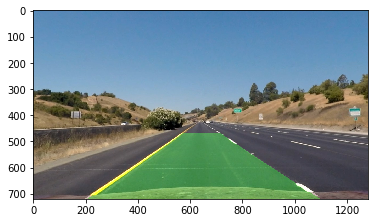

In [13]:
out_img = np.dstack((warped_img, warped_img, warped_img))*255

y_points = np.linspace(0, num_rows-1, num_rows)

left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))

right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))

line_points = np.vstack((left_line_window, right_line_window))

cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])

unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)

result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)

plt.imshow(result)

## FINAL PIPELINE

In [14]:
# Some global variables
polyfit_left=None
polyfit_right=None

past_good_left_lines = []
past_good_right_lines = []

running_mean_difference_between_lines = 0

def get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows):
    """
        Given ncoordinates of non-zeros pixels and coordinates of non-zeros pixels within the sliding windows,
        this function generates a prediction for the lane line.
    """
    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]
    
    # If no pixels were found return None
    if(left_y.size == 0 or left_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_left = np.polyfit(left_y, left_x, 2)

    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]
    
    # If no pixels were found return None
    if(right_y.size == 0 or right_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_right = np.polyfit(right_y, right_x, 2)

    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    # Generate the lane lines from the polynomial fit
    left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
    right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    
    return left_x_predictions, right_x_predictions

def brute_search(warped):
    """
        This function searches for lane lines from scratch.
        Thresholding & performing a sliding window search.
    """
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    
    histogram = np.sum(warped[round(warped.shape[0]/2):,:], axis=0)

    half_width = np.int(histogram.shape[0]/2)
    leftpeak = np.argmax(histogram[:half_width])
    rigthpeak = np.argmax(histogram[half_width:]) + half_width

    num_windows = 10
    window_height = np.int(num_rows/num_windows)
    window_half_width = 50

    min_pixels = 100

    left_coordinates = []
    right_coordinates = []

    for window in range(num_windows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height

        left_x_min = leftpeak - window_half_width
        left_x_max = leftpeak + window_half_width

        good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)

        if len(good_left_window_coordinates) > min_pixels:
            leftpeak = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))

        right_x_min = rigthpeak - window_half_width
        right_x_max = rigthpeak + window_half_width

        good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)

        if len(good_right_window_coordinates) > min_pixels:
            rigthpeak = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    
    left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    return left_x_predictions, right_x_predictions

def get_averaged_line(previous_lines, new_line):
    """
        This function computes an averaged lane line by averaging over previous good frames.
    """
    
    # Number of frames to average over
    num_frames = 12
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line
        
        
def get_mean_distance_between_lines(left_line, right_line, running_average):
    """
        Returns running weighted average of simple difference between left and right lines
    """
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average
    

def pipeline_final(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    img_shape = img.shape
    img_size = (image_shape[1], image_shape[0])
    
    # get thresholded image
    thresholded = image_thresholding(img)
    
    # perform a perspective transform
    warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    
    out_img = np.dstack((warped, warped, warped))*255
    
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then perform a brute force search
        brute = True
        left_x_predictions, right_x_predictions = brute_search(warped)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        brute = False
        margin = 100
        left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
        left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

        right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
        right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]
        
        left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    
    if (left_x_predictions is None or right_x_predictions is None):
        if not brute:
            left_x_predictions, right_x_predictions = brute_search(warped)
            
    bad_lines = False
            
    if (left_x_predictions is None or right_x_predictions is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
            if not brute:
                left_x_predictions, right_x_predictions = brute_search(warped)
                if (left_x_predictions is None or right_x_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return img
        else:
            left_x_predictions = past_good_left_lines[-1]
            right_x_predictions = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_x_predictions = get_averaged_line(past_good_left_lines, left_x_predictions)
        past_good_right_lines, right_x_predictions = get_averaged_line(past_good_right_lines, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
    
    # compute the radius of curvature
    left_curve_rad = measure_radius_of_curvature(left_x_predictions)
    right_curve_rad = measure_radius_of_curvature(right_x_predictions)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (right_x_predictions[num_rows-1] + left_x_predictions[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

# RESULTS

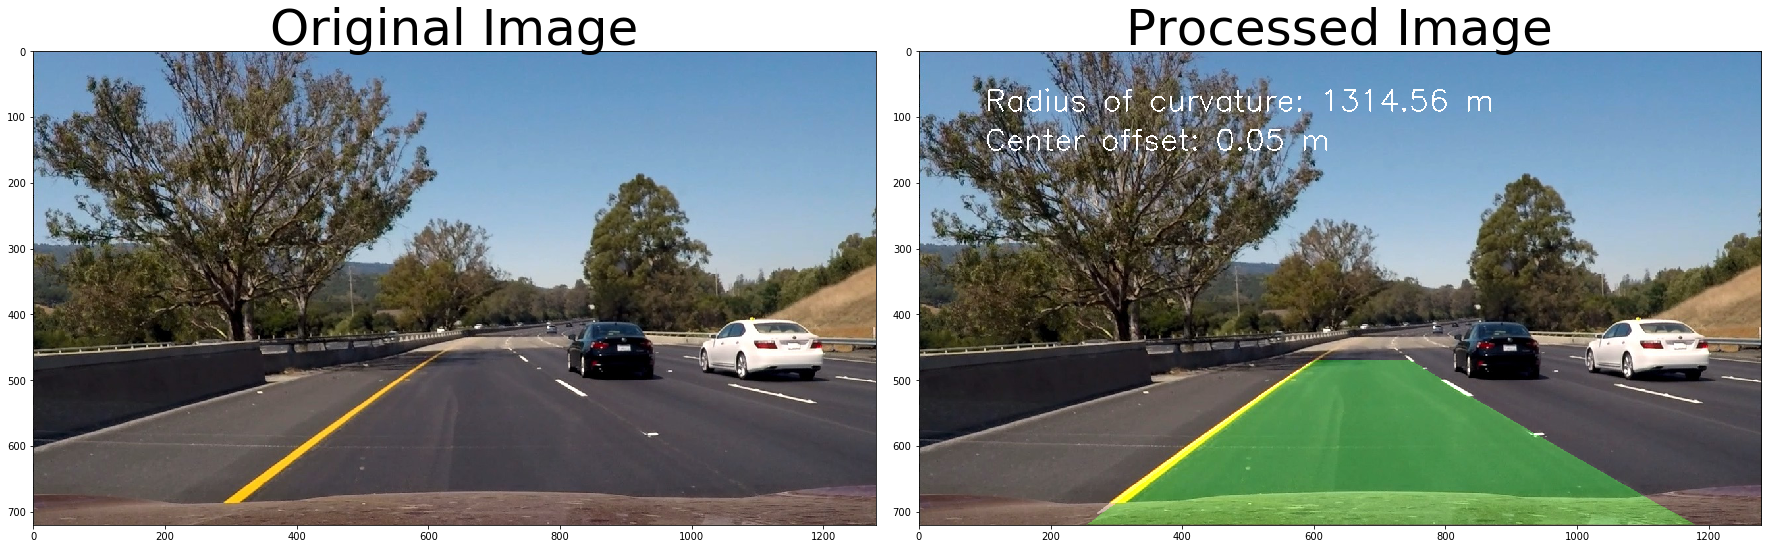

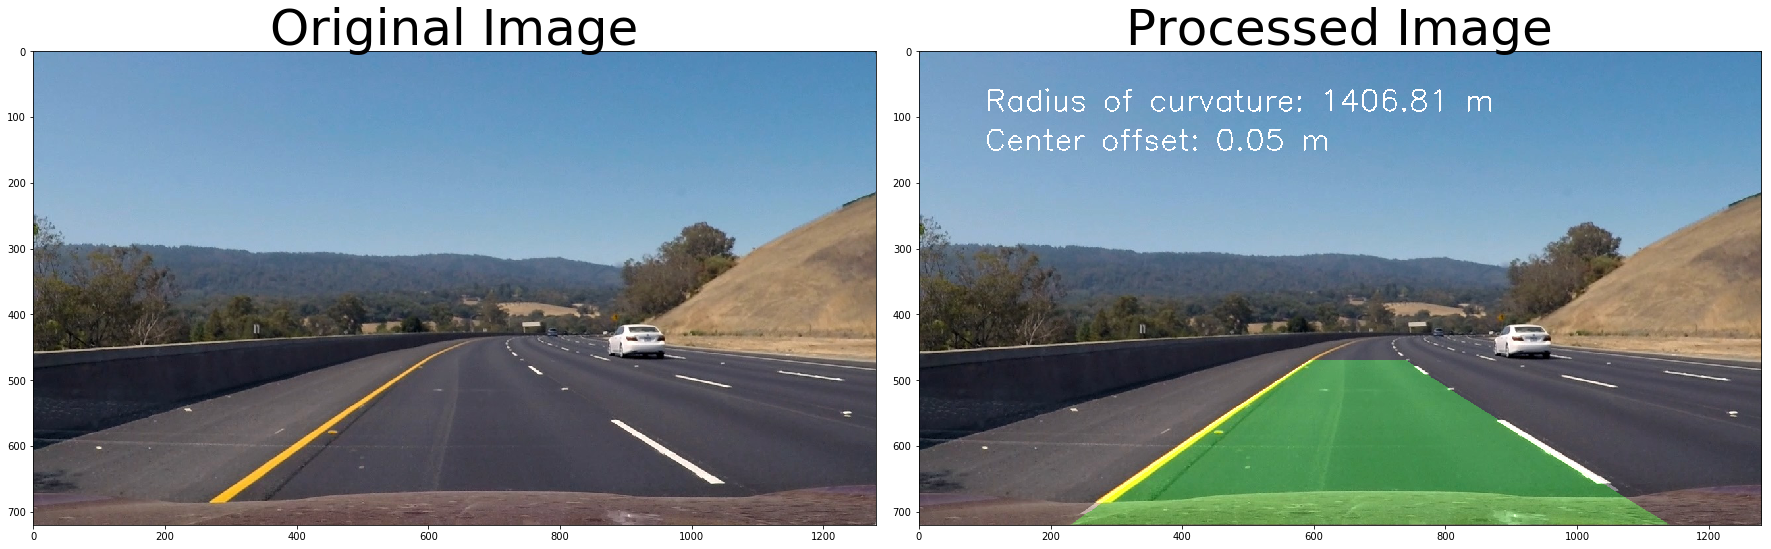

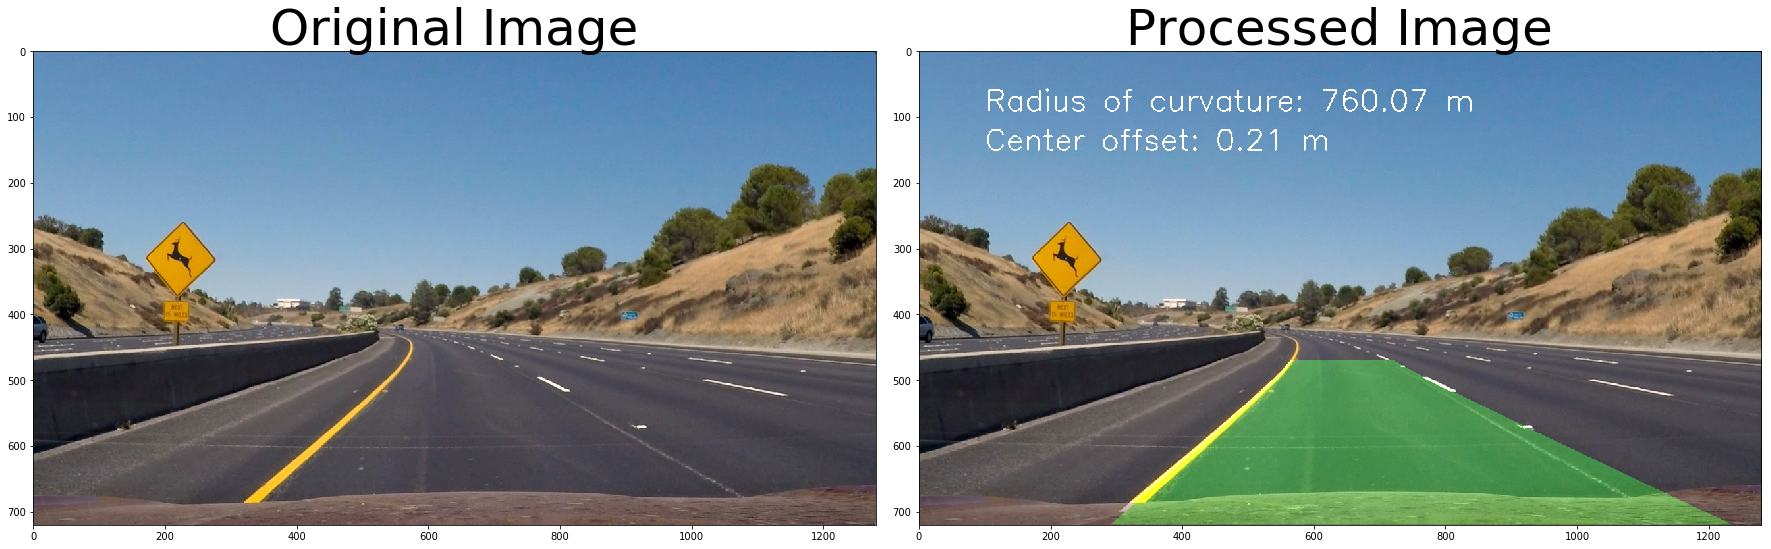

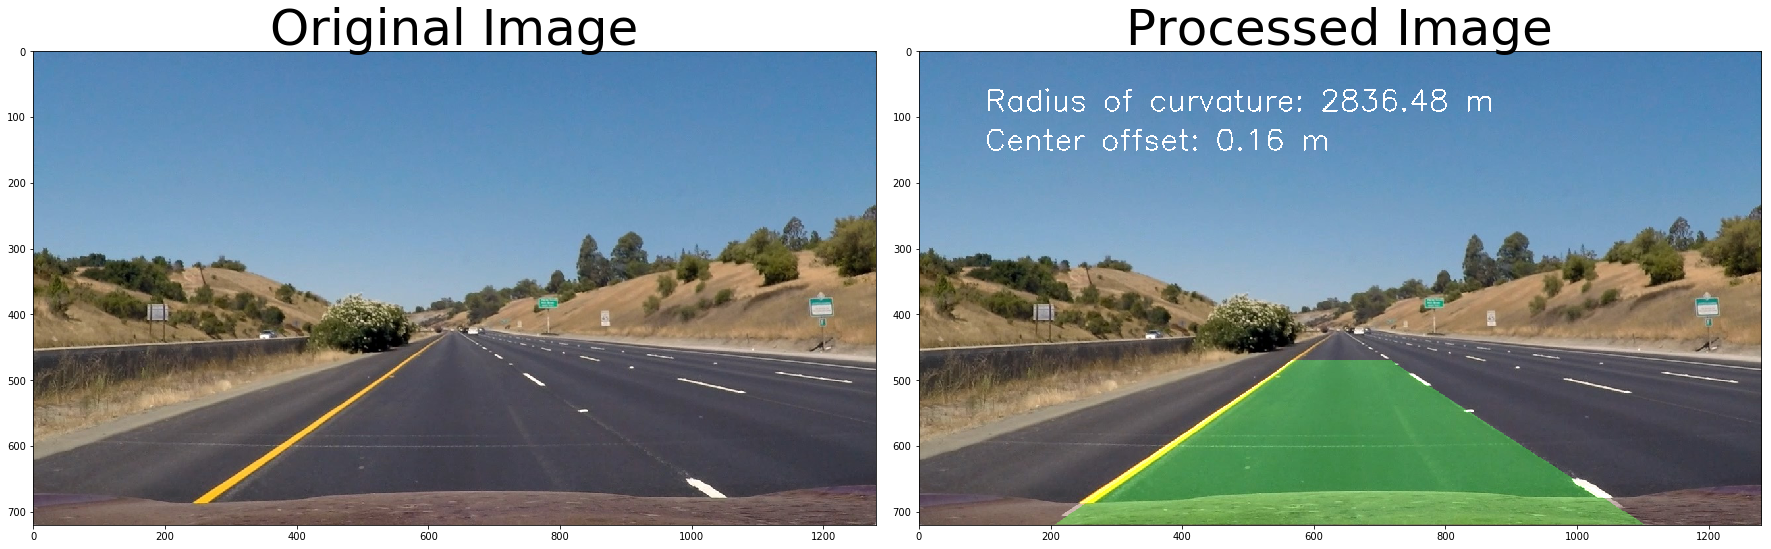

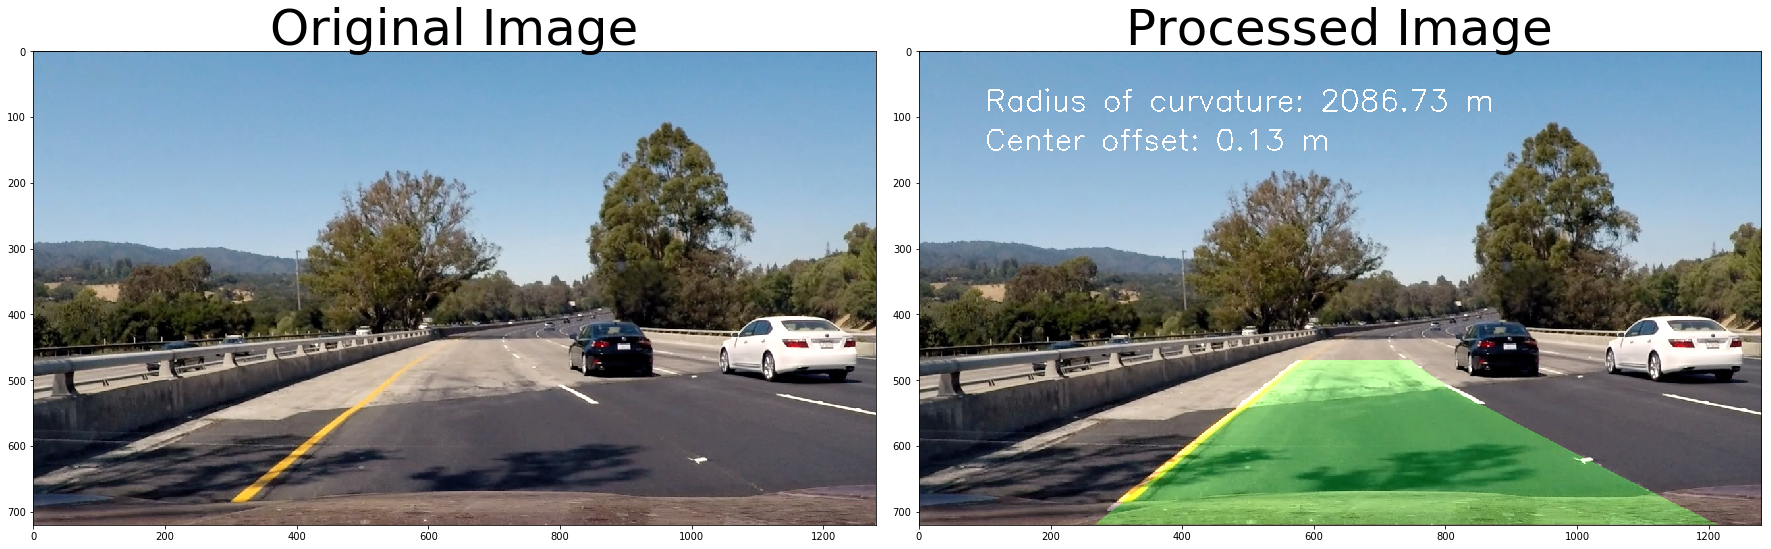

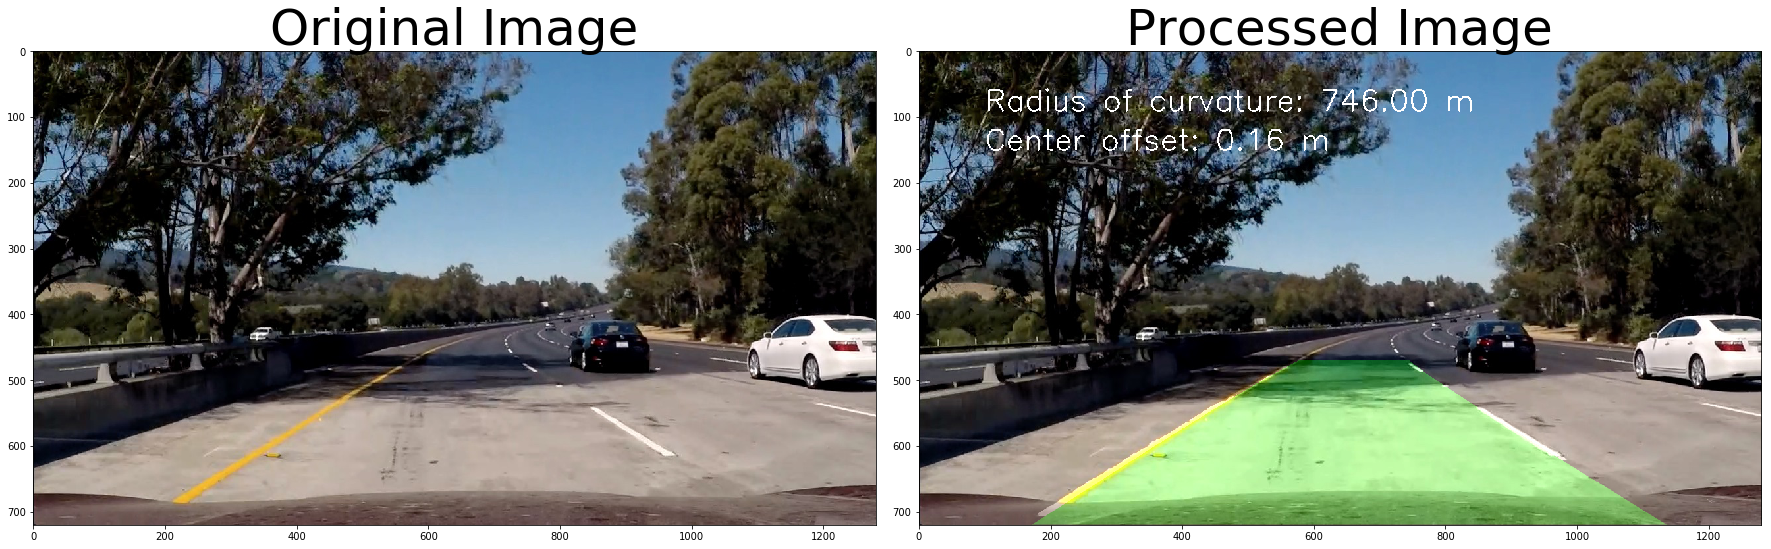

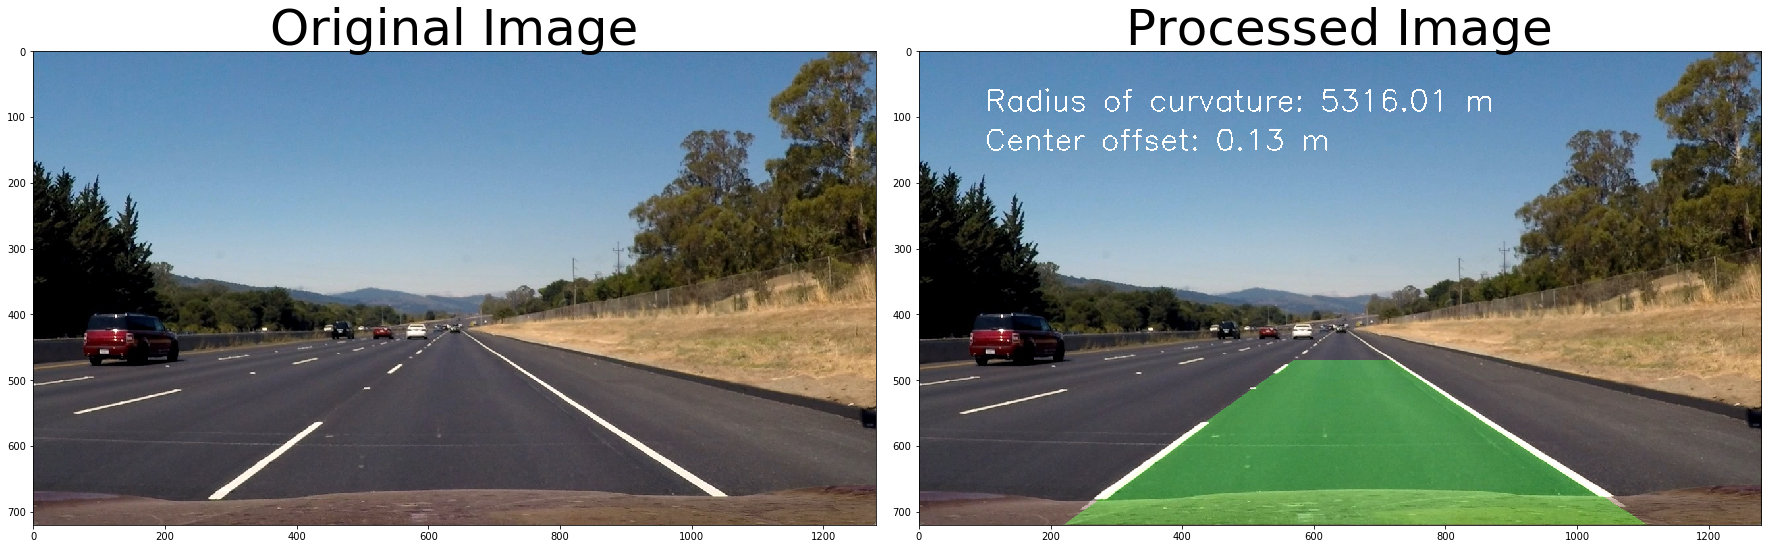

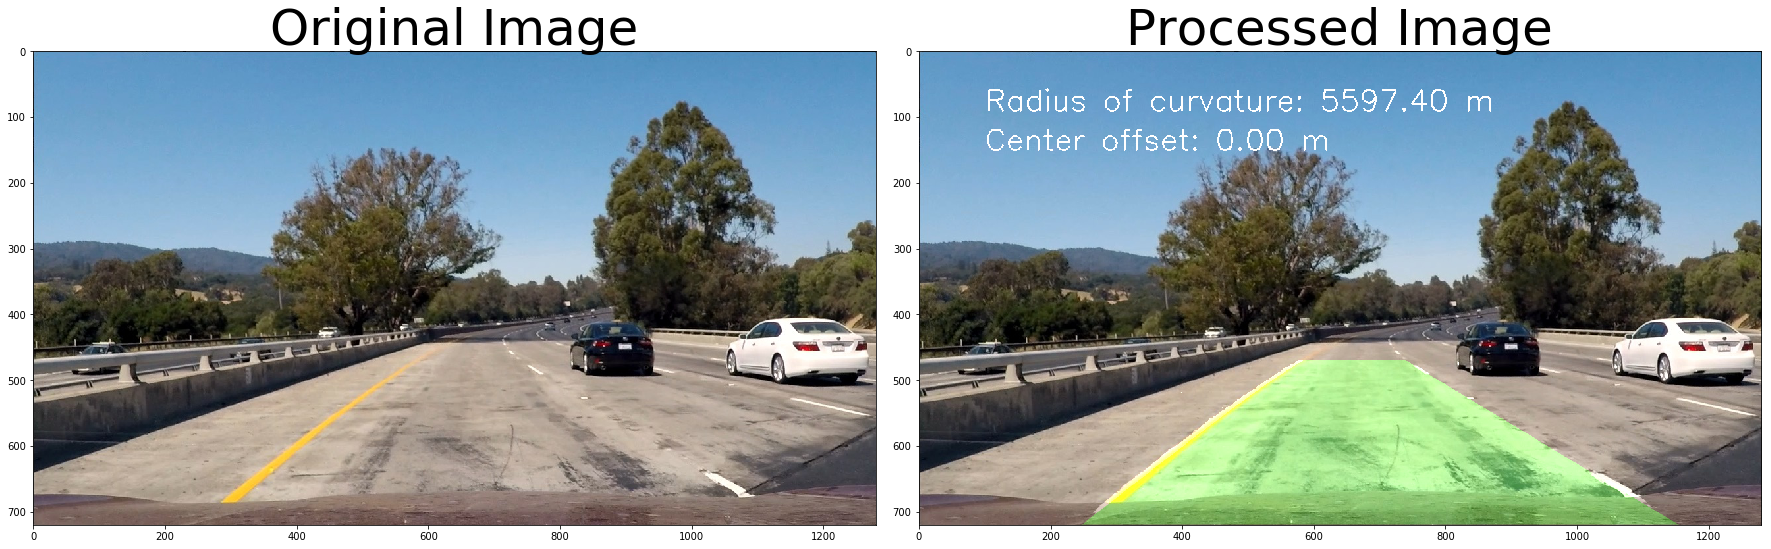

In [15]:
folder = 'test_images'
for filename in os.listdir(folder):
    image = mpimg.imread(os.path.join(folder, filename))
# Reinitialize some global variables.
    polyfit_left = None
    polyfit_right = None
    past_good_right_lines = []
    past_good_left_lines = []
    running_mean_difference_between_lines = 0

    # Apply pipeline
    processed = pipeline_final(image)

    # Plot the 2 images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(processed)
    ax2.set_title('Processed Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    cv2.imwrite('output_images/%s'%filename, cv2.cvtColor(processed, cv2.COLOR_RGB2BGR))

## VIDEO PIPELINE

### Project Video

In [16]:
from moviepy.editor import VideoFileClip
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0


output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:44<00:00,  4.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 15min 16s, sys: 21.6 s, total: 15min 38s
Wall time: 4min 45s


### Challenge Video

In [17]:
from moviepy.editor import VideoFileClip
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0
hmm

output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:55<00:00,  3.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 5min 58s, sys: 8.25 s, total: 6min 7s
Wall time: 1min 56s


### Harder Challenge Video

In [ ]:
from moviepy.editor import VideoFileClip
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0


output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


 23%|██▎       | 272/1200 [01:03<03:07,  4.96it/s]